MRC Gain
========

This notebook illustrates the gains obtained when using MRC in a SIMO system. It reproduces the results found [here](http://www.dsplog.com/2008/09/28/maximal-ratio-combining/).

Initializations
---------------

First we set the Python path and import some libraries.

In [1]:
%pylab inline
from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


In [2]:
# xxxxxxxxxx Add the parent folder to the python path. xxxxxxxxxxxxxxxxxxxx
import sys
import os
sys.path.append('../')
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

import numpy as np
from pyphysim.util.misc import randn_c
from pyphysim.util.conversion import linear2dB

Now we set the simulation parameters

In [3]:
all_N = np.arange(1,21)  # Number of receive antennas
rep_max = 10000  # Number of iterations
rep_max = 10000  # Number of iteration

Simulation
----------

Now we simulate the MRC gain.

In [4]:
SNR_gain_dB = np.empty(all_N.size)
for index in range(all_N.size):
    all_gains = np.empty(rep_max)
    for rep in range(rep_max):
        N = all_N[index]
        # Generate the random channel matrix (here a column vector)
        H = randn_c(N, 1)
        all_gains[rep] = np.dot(H.transpose().conjugate(), H)[0,0].real
    SNR_gain_dB[index] = linear2dB(np.mean(all_gains))

SNR_gain_dB_theory = linear2dB(all_N)

Plotting
--------

Now we can finally plot the SNR gain obtained with MRC.

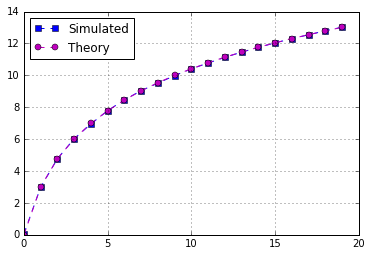

In [5]:
from matplotlib import pyplot as plt
plt.plot(SNR_gain_dB,'--bs', label='Simulated')
plt.plot(SNR_gain_dB_theory,'--mo', label='Theory')

plt.legend(loc='best')
plt.grid()
plt.show()

Error rate with Maximal Ratio Combining (MRC)
=============================================

Now lets simulate an actual transmission with MRC. We simulate a BPSK transmission with MRC through a Rayleight channel.

First lets reset the variables in the workspace to guarantee we are not using anything from previous cells

In [6]:
# Reset the variables in the workspace
%reset -f
from IPython.display import clear_output

Now lets make some initialization setting the Python path.

In [8]:
# Add parent folder to path and import the required modules
import numpy as np
import sys
sys.path.append('../')
from pyphysim.util.conversion import dB2Linear
from pyphysim.util.misc import randn_c, count_bit_errors
from pyphysim.simulations.progressbar import ProgressbarText,ProgressbarText2

Now we define a function to simulate for the given transmission parameters.

In [9]:
def simulate_MRC(SNR, N, NSymbs, num_reps):
    """Simulate the BPSK transmission with MRC with the given parameters

    Params
    ------
    SNR : double
        The desired SNR value (in dB)
    N : int
        The number of receive antennas (the number of transmit antennas is always 1).
    NSymbs : int
        The number of transmitted symbols at each iteration
    num_reps : int
        The number of iterations.
    """
    bit_errors = 0.0
    num_bits = NSymbs * num_reps
    for rep in range(num_reps):
        # Dependent Variables
        noise_var = 1.0 / dB2Linear(SNR)

        # Generates random data with 0 and 1
        input_data = np.random.randint(0, 2, NSymbs)

        # Modulate the data with BPSK
        symbols = 1 - 2 * input_data

        # Generate the complex channel
        h = randn_c(N, 1)

        # Pass the data through the channel
        received_data = h * symbols + (np.sqrt(noise_var) * randn_c(1, NSymbs))  # This will use numpy broadcasting

        # Apply the MRC
        improved_received_data = np.dot(h.transpose().conjugate(), received_data)

        # Decode the received data
        decoded_data = np.zeros(NSymbs, dtype=int)
        improved_received_data = np.squeeze(improved_received_data)
        decoded_data[improved_received_data < 0] = 1

        # Count the number of bit errors
        bit_errors += count_bit_errors(input_data, decoded_data)

    # Calculate the BER
    BER = float(bit_errors) / num_bits

    return BER

Now we can finally perform the simulation for varying sets of transmission parameters.

In [ ]:
# Transmission parameters
NSymbs = 200  # Number of simulated symbols
NBits = NSymbs
all_SNR = np.linspace(0, 35, 14)
num_reps = 30000

# Number of SNR points
num_points = all_SNR.size

BER_NRx1 = np.zeros(num_points)
BER_NRx2 = np.zeros(num_points)

pbar = ProgressbarText2(num_points, message="Simulating")

for index in range(num_points):
    pbar.progress(index)
    SNR = all_SNR[index]
    BER_NRx1[index] = simulate_MRC(SNR, 1, NSymbs, num_reps)
    BER_NRx2[index] = simulate_MRC(SNR, 2, NSymbs, num_reps)

pbar.progress(num_points)

# Clear the progressbar output at the end
clear_output()

[******                 14%                      ]  Simulating

Now we plot the results.

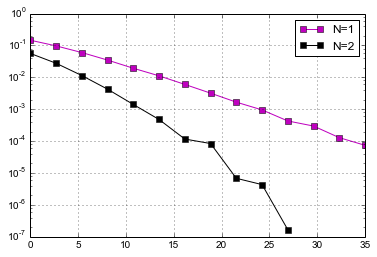

In [10]:
from matplotlib import pyplot as plt

plt.semilogy(all_SNR, BER_NRx1, '-ms')
plt.semilogy(all_SNR, BER_NRx2,'-ks')
plt.legend(['N=1', 'N=2'])
plt.grid()
plt.show()

In [11]:
#%qtconsole